In [1]:
import json
import plotly
import warnings
import numpy as np
import plotly.graph_objects as go

from glob import glob
from scipy.stats import poisson
from plotly.subplots import make_subplots

plotly.offline.init_notebook_mode()
warnings.filterwarnings('ignore')

In [2]:
def generate_tables(competition='Serie_A', max_goals=5, decimals=4):
    observed_data = np.zeros((max_goals + 1, max_goals + 1))
    home_goals = 0
    away_goals = 0
    games = 0
    for file in glob(f'../../Data/results/processed/{competition}*games.json'):
        with open(file, 'r') as f: data = json.load(f)
        for game in data:
            result = data[game]['Result'].upper().split(' X ')
            score_h, score_a = int(result[0]), int(result[1])
            
            games += 1
            home_goals += score_h
            away_goals += score_a
            observed_data[min(score_a, max_goals), min(score_h, max_goals)] += 1

    home_mean, away_mean = home_goals / games, away_goals / games
    poisson_home, poisson_away = poisson(home_mean), poisson(away_mean)
    home_probs = [poisson_home.pmf(x) for x in [*range(max_goals)]]
    away_probs = [poisson_away.pmf(x) for x in [*range(max_goals)]]
    home_probs.append(1 - sum(home_probs))
    away_probs.append(1 - sum(away_probs))
    home_probs, away_probs = np.array(home_probs), np.array(away_probs)
    theorical_data = np.zeros((max_goals + 1, max_goals + 1))
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            theorical_data[j, i] = home_probs[i] * away_probs[j]

    observed_data = np.round(observed_data / games, decimals)
    theorical_data = np.round(theorical_data, decimals)

    return observed_data, theorical_data

In [3]:
def plot_heatmaps(observed_data, theorical_data, competition):
    max_goals = observed_data.shape[0] - 1
    labels = [f'{i}' for i in range(max_goals)] + [f'{max_goals}+']
    z_min = min(np.min(theorical_data), np.min(observed_data))
    z_max = max(np.max(theorical_data), np.max(observed_data))

    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Heatmap(z=theorical_data, x=labels, y=labels, zmin=z_min, zmax=z_max, text=theorical_data, hoverinfo='text'), row=1, col=1)
    fig.add_trace(go.Heatmap(z=observed_data, x=labels, y=labels, zmin=z_min, zmax=z_max), row=1, col=2)

    for i in range(len(labels)):
        for j in range(len(labels)):
            fig.add_annotation(
                x=labels[j],
                y=labels[i],
                text=str(theorical_data[i][j]),
                showarrow=False,
                font=dict(color='white', size=12),
                xref='x1',
                yref='y1'
            )

            fig.add_annotation(
                x=labels[j],
                y=labels[i],
                text=str(observed_data[i][j]),
                showarrow=False,
                font=dict(color='white', size=12),
                xref='x2',
                yref='y2'
            )

    fig.update_xaxes(side='top', tickmode='array', tickvals=list(range(len(labels))), ticktext=labels, row=1, col=1)
    fig.update_yaxes(autorange='reversed', tickmode='array', tickvals=list(range(len(labels))), ticktext=labels, row=1, col=1)
    fig.update_xaxes(side='top', tickmode='array', tickvals=list(range(len(labels))), ticktext=labels, row=1, col=2)
    fig.update_yaxes(autorange='reversed', tickmode='array', tickvals=list(range(len(labels))), ticktext=labels, row=1, col=2)
    fig.update_layout(
        xaxis=dict(side='bottom', title='Home goals'),
        yaxis=dict(autorange='reversed', title='Away goals'),
        xaxis2=dict(side='bottom', title='Home goals'),
        yaxis2=dict(autorange='reversed', title='Away goals'),
        title=dict(text=competition.replace('_', ' ') + '<br>Theoretical vs. Observed', x=0.5)
    )

    fig.update_layout(height=400, width=800, margin=dict(l=50, r=50, t=50, b=50))
    fig.show('png')

In [4]:
def visualize_competition(competition='Serie_A', max_goals=5, decimals=4):
    observed_data, theorical_data = generate_tables(competition, max_goals, decimals)
    plot_heatmaps(observed_data, theorical_data, competition)

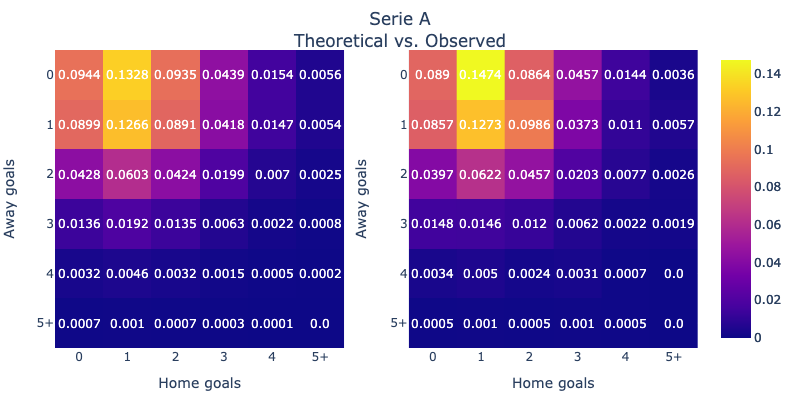

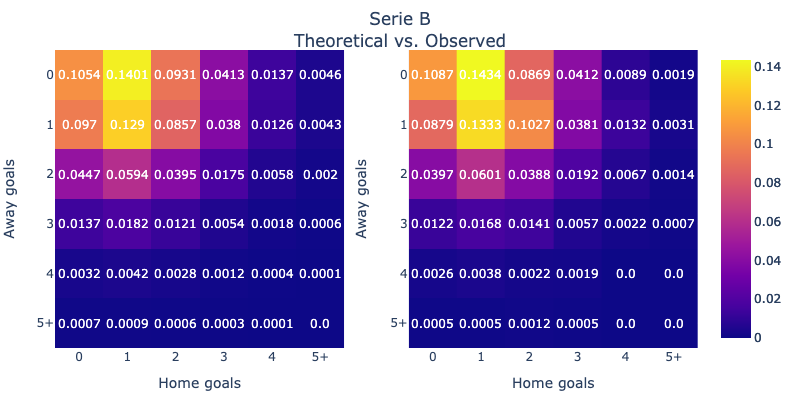

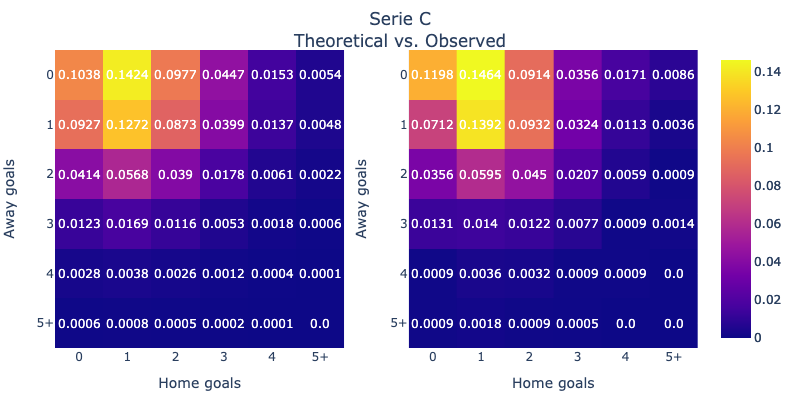

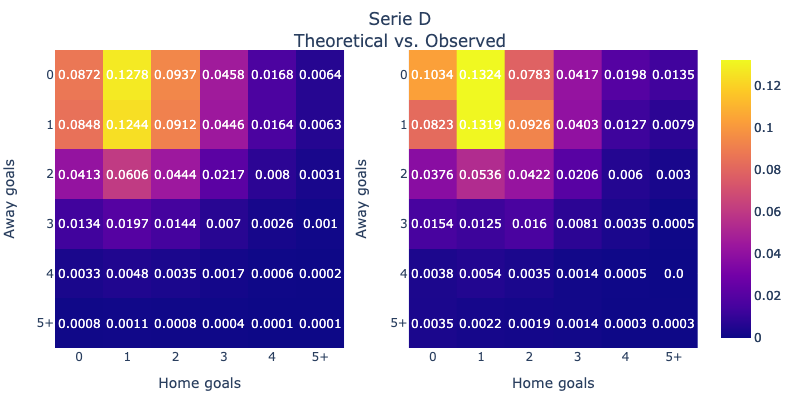

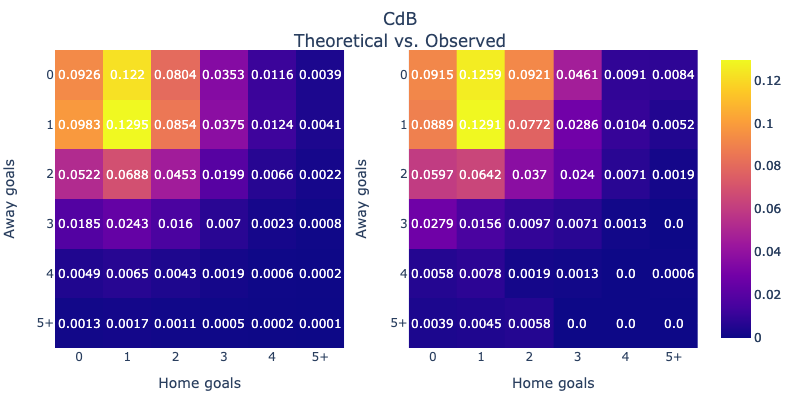

In [5]:
for comp in ['Serie_A', 'Serie_B', 'Serie_C', 'Serie_D', 'CdB']: visualize_competition(comp, max_goals=5, decimals=4)